This notebook illustrates applications of iterative projection algorithms.

Date Created: 4 Oct 2020
<br>
Last Modified: 12 Sep 2023

# Outline
* Phase retrieval
* IPA Application

# 1.0 Phase retrieval

In [1]:
%matplotlib inline

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import time

from numpy.fft import fftn, ifftn, fftshift, ifftshift

In [2]:
from matplotlib.pyplot import imread
from skimage import color
from skimage import transform

Nx = 64
Ny = 64

x_true = imread("data/cat.png")
x_true = x_true[:,:,0] #color.rgb2gray(x_true)
x_true = transform.resize(x_true, (Nx, Ny))
x_true /= np.max(x_true)
x_true[x_true < 1e-1] = 0

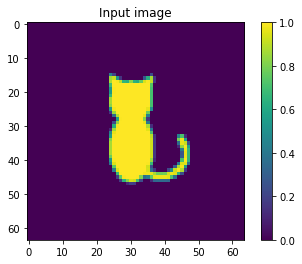

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(x_true)
plt.colorbar(im)
ax.set_title('Input image')

plt.show()

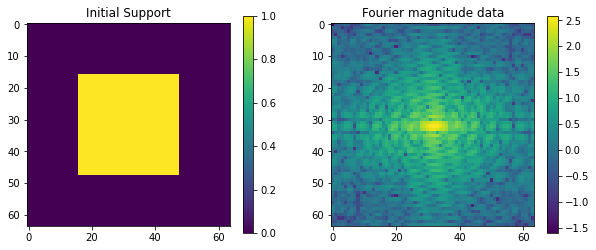

In [4]:
# Now take the Fourier transform of the cat
X_true = fftn(x_true)
M_true = np.abs(X_true)

# Make initial support
supp = np.zeros([Nx,Ny])
supp[16:48,16:48] = 1

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
im = ax.imshow(supp)
plt.colorbar(im)
ax.set_title('Initial Support')
ax = fig.add_subplot(122)
im = ax.imshow(np.log10(fftshift(M_true)))
plt.colorbar(im)
ax.set_title('Fourier magnitude data')

plt.show()

## Projection operators

In [5]:
def P_S(x, S_in):
    x_new = x * S_in['supp']
    return x_new

In [6]:
def P_M(x, M_in):
    X = fftn(x)
    X_new = X/np.abs(X) * M_in['M_data']
    x_new = ifftn(X_new)
    return x_new

## Difference Map
$$
R_M x_n = (1+\gamma_M) P_M x_n - \gamma_M x_n
$$
$$
R_S x_n = (1+\gamma_S) P_S x_n - \gamma_S x_n
$$

$$
x_{n+1} = x_n + \beta \; (P_S R_M x_n - P_M R_S x_n)
$$

Elser (2003) Phase retrieval by iterated projections, J Opt Soc Am A. Vol 20, pp 40-55.


In [7]:
def R_M(x, gamma_M, M_in):
    return (1+gamma_M)*P_M(x, M_in) - gamma_M*x

def R_S(x, gamma_S, S_in):
    return (1+gamma_S)*P_S(x, S_in) - gamma_S*x

def DM(x, beta, gamma_S, gamma_M):
    x_PS = P_S(R_M(x, gamma_M, M_in), S_in)
    x_PM = P_M(R_S(x, gamma_S, S_in), M_in)

    x_new = x + beta*(x_PM - x_PS)

    return x_new, x_PS

## Shrinkwrap

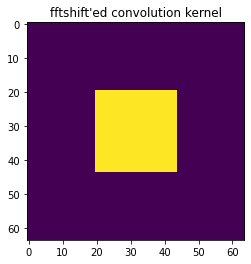

In [8]:
C_lp = np.zeros([Nx,Ny])
C_lp[20:44,20:44] = 1
C_lp = ifftshift(C_lp)

fig = plt.figure(figsize=(12,4))
# ax = fig.add_subplot(121)
# im = ax.imshow(C_lp)
# ax.set_title('Convolution kernel')
ax = fig.add_subplot(121)
im = ax.imshow(fftshift(C_lp))
ax.set_title('fftshift\'ed convolution kernel')

plt.show()

In [9]:
def convolution_filter(x, kernel):
    return ifftn(fftn(x) * kernel)

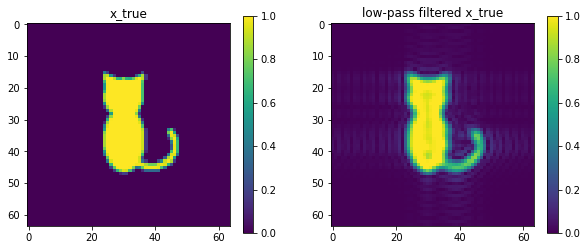

In [10]:
x_lp = convolution_filter(x_true, kernel=C_lp)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
im = ax.imshow(x_true, clim=[0,1])
plt.colorbar(im)
ax.set_title('x_true')

ax = fig.add_subplot(122)
im = ax.imshow(np.abs(x_lp), clim=[0,1])
plt.colorbar(im)
ax.set_title('low-pass filtered x_true')

plt.show()

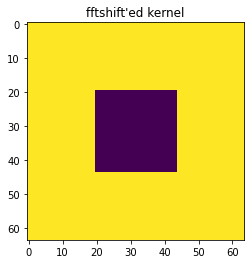

In [11]:
C_hp = 1 - C_lp

fig = plt.figure(figsize=(10,4))
# ax = fig.add_subplot(121)
# im = ax.imshow(C_hp)
# ax.set_title('Highpass kernel')

ax = fig.add_subplot(121)
im = ax.imshow(fftshift(C_hp))
ax.set_title('fftshift\'ed kernel')

plt.show()

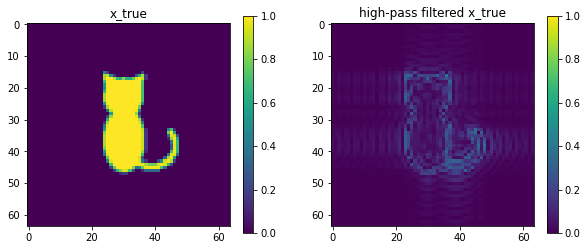

In [12]:
x_hp = convolution_filter(x_true, kernel=C_hp)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
im = ax.imshow(x_true, clim=[0,1])
plt.colorbar(im)
ax.set_title('x_true')

ax = fig.add_subplot(122)
im = ax.imshow(np.abs(x_hp), clim=[0,1])
plt.colorbar(im)
ax.set_title('high-pass filtered x_true')

plt.show()

## Phase retrieval start!

<IPython.core.display.Javascript object>


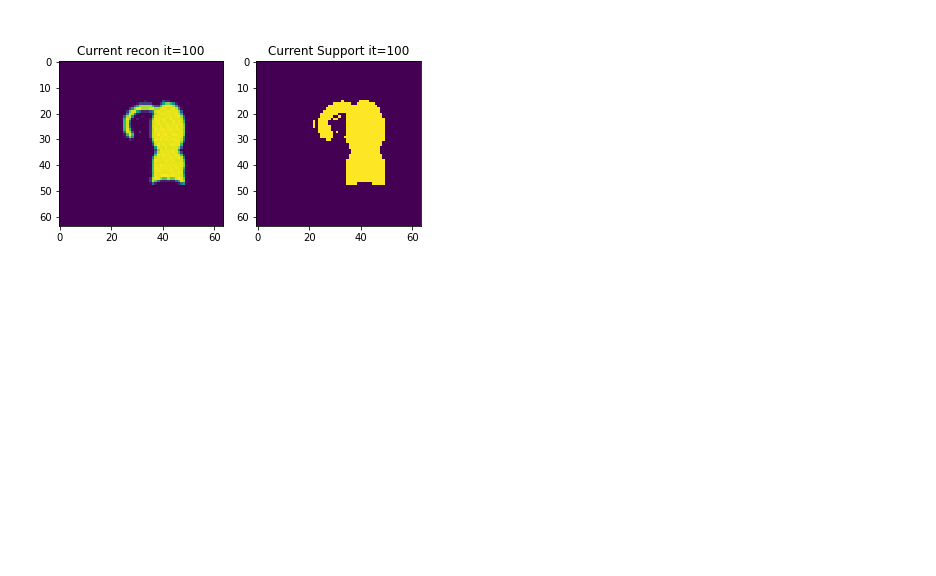

In [13]:
%matplotlib notebook

np.random.seed(41)

# Make initial support - just a box
supp = np.zeros([Nx,Ny])
supp[16:48,16:48] = 1

# Input data to the algorithm
S_in = {'supp':supp}
M_in = {'M_data':M_true}

it_max = 101

# DM parameters
beta = 0.7
gamma_M = -1/beta
gamma_S = 1/beta

# Starting iterate
x = np.random.rand(Nx,Ny)


fig = plt.figure(figsize=(6.5,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for it in range(it_max):
    
    # Update rule: Difference Map
    x, x_PS = DM(x, beta, gamma_S, gamma_M)
    
    x_sol = x_PS
    
    # Shrinkwrap
    if it % 10 == 9:
        x_mod = convolution_filter(x_sol, kernel=C_lp)
        x_mod = np.abs(x_mod)
        x_mod /= np.max(x_mod)
        supp = x_mod > 0.12
        S_in = {'supp':supp}
    
    # Visualize
    im = ax1.imshow(np.abs(x_sol), interpolation='nearest')
    ax1.set_title("Current recon it=%d" % it)
    im = ax2.imshow(supp, interpolation='nearest')
    ax2.set_title("Current Support it=%d" % it)
        
    fig.canvas.draw()
    
    time.sleep(0.01)
    
    # Clear axes every second iteration
    if it % 2 == 1:
        ax1.cla()
        ax2.cla()


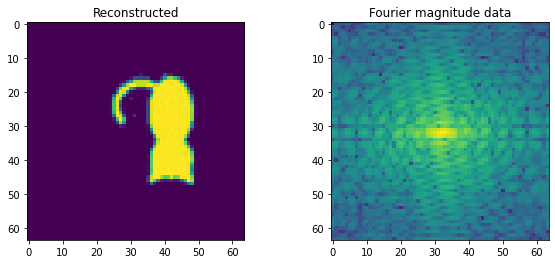

In [14]:
%matplotlib inline

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
im = ax.imshow(np.abs(x_sol), clim=[0,1])
ax.set_title('Reconstructed')
ax = fig.add_subplot(122)
im = ax.imshow(np.log10(fftshift(M_true)))
ax.set_title('Fourier magnitude data')

plt.show()

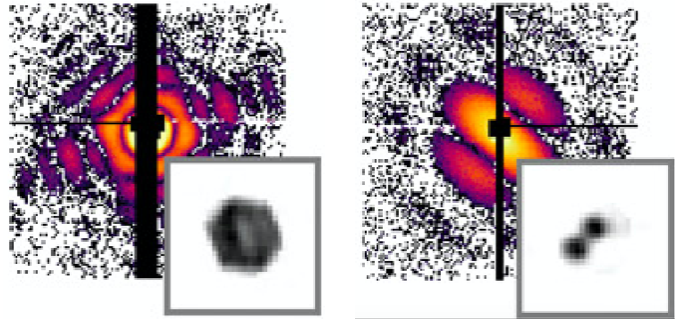

In [15]:
Image(filename='images/sample.png', width=700)
# Image ref: Bielecki et al. (2019)

# 2.0 Sudoku

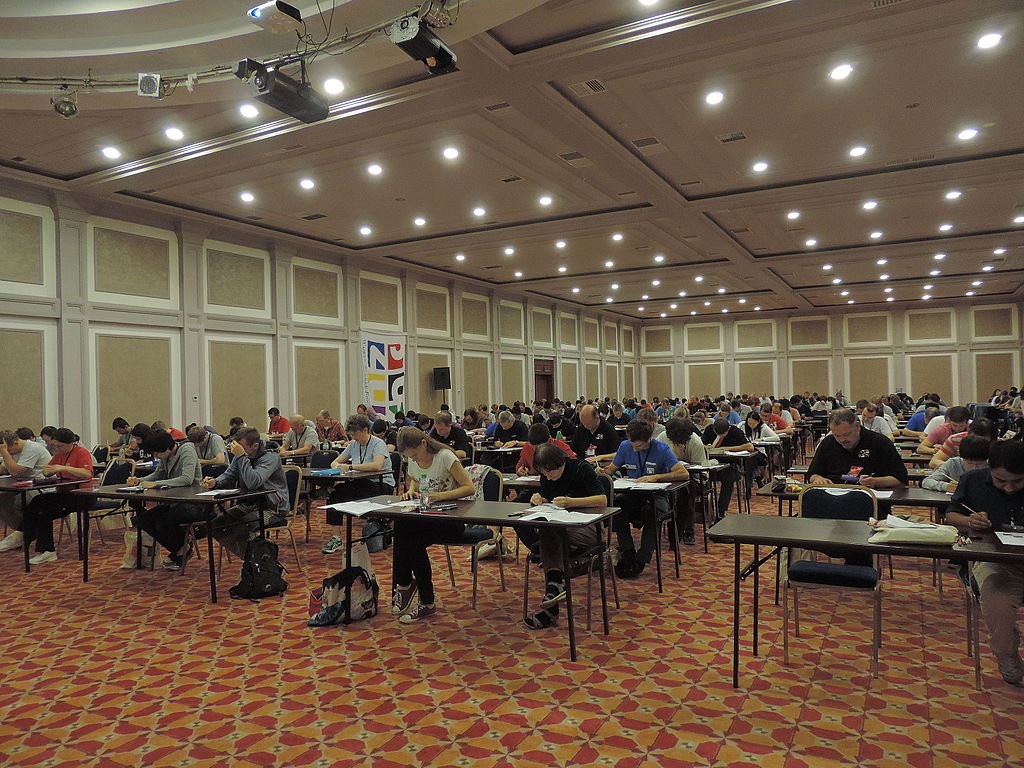

In [16]:
Image(filename='images/sudoku1.jpg', width=700)
# Image ref: https://en.wikipedia.org/wiki/World_Sudoku_Championship

In [17]:
# Number of symbols
N_symbols = 9

N_constraints = 4

# Known entries - (x,y,value)
g = np.array([[1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9],
              [1, 2, 5, 1, 4, 5, 6, 2, 3, 8, 1, 5, 9, 1, 4, 6, 9, 1, 5, 9, 2, 7, 8, 4, 5, 6, 9, 5, 8, 9],
              [5, 3, 7, 6, 1, 9, 5, 9, 8, 6, 8, 6, 3, 4, 8, 3, 1, 7, 2, 6, 6, 2, 8, 4, 1, 9, 5, 8, 7, 9]])
g = g - 1 # Python indices start at 0

N_known = g.shape[1]

# Solution
x_true_sudoku = np.array([[5,3,4,6,7,8,9,1,2], 
                          [6,7,2,1,9,5,3,4,8], 
                          [1,9,8,3,4,2,5,6,7],
                          [8,5,9,7,6,1,4,2,3],
                          [4,2,6,8,5,3,7,9,1],
                          [7,1,3,9,2,4,8,5,6],
                          [9,6,1,5,3,7,2,8,4],
                          [2,8,7,4,1,9,6,3,5],
                          [3,4,5,2,8,6,1,7,9]])

In [18]:
x_true_sudoku

array([[5, 3, 4, 6, 7, 8, 9, 1, 2],
       [6, 7, 2, 1, 9, 5, 3, 4, 8],
       [1, 9, 8, 3, 4, 2, 5, 6, 7],
       [8, 5, 9, 7, 6, 1, 4, 2, 3],
       [4, 2, 6, 8, 5, 3, 7, 9, 1],
       [7, 1, 3, 9, 2, 4, 8, 5, 6],
       [9, 6, 1, 5, 3, 7, 2, 8, 4],
       [2, 8, 7, 4, 1, 9, 6, 3, 5],
       [3, 4, 5, 2, 8, 6, 1, 7, 9]])

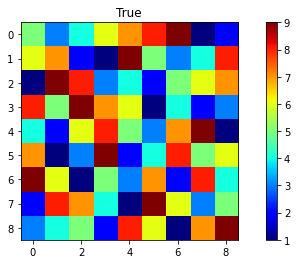

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
im = ax.imshow(x_true_sudoku, cmap='jet')
ax.set_title("True")
plt.colorbar(im)
plt.show()

/var/folders/dw/3pt2_w855cd7w3pwfhkfblzr0000gn/T/ipykernel_11830/1011048181.py:47: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


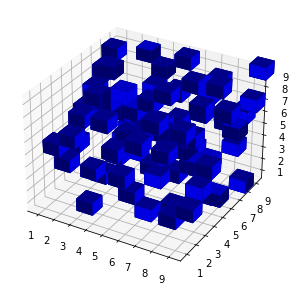

In [21]:
from mpl_toolkits.mplot3d import Axes3D

# Voxel plotting code from:
# https://stackoverflow.com/questions/42611342/representing-voxels-with-matplotlib

def cuboid_data(pos, size=(1,1,1)):
    """ Defining a cuboid """
    o = [a - b / 2 for a, b in zip(pos, size)]
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1], o[1], o[1]],          
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]   
    z = [[o[2], o[2], o[2], o[2], o[2]],                       
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],   
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],               
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]               
    return np.array(x), np.array(y), np.array(z)

def plotCubeAt(pos=(0,0,0),ax=None):
    """ Plotting a cube element at position pos """
    if ax !=None:
        X, Y, Z = cuboid_data( pos )
        ax.plot_surface(X, Y, Z, color='b', rstride=1, cstride=1, alpha=1)

def plotVolume(ax, v):
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            for k in range(v.shape[2]):
                if v[i,j,k] == 1:
                    plotCubeAt(pos=(i-0.5+2,j-0.5+2,k-0.5+2), ax=ax)            


                    
x_true = np.zeros([N_symbols, N_symbols, N_symbols])

for i in range(N_symbols):
    for j in range(N_symbols):
        x_true[i, j, x_true_sudoku[i,j]-1] = 1
        
        
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
# ax.set_aspect('equal')
ax.set_xlim(0.5,9.5)
ax.set_ylim(0.5,9.5)
ax.set_zlim(0.5,9.5)

plotVolume(ax, x_true)

plt.show()

## The Hungarian Algorithm

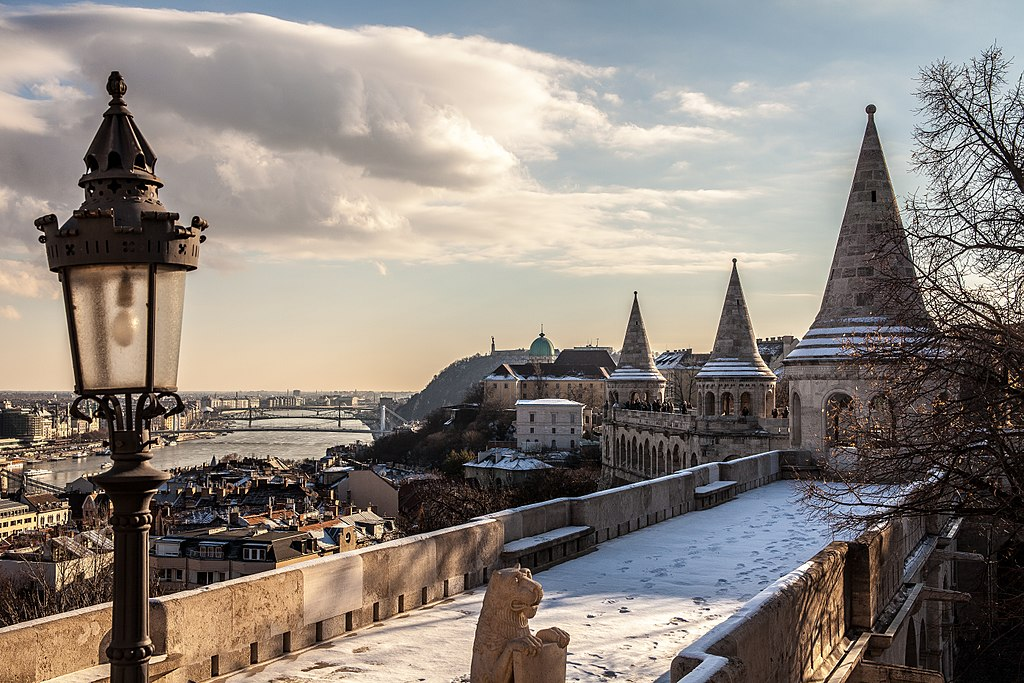

In [22]:
Image(filename='images/buda.jpg', width=800)
# Image ref: https://en.wikipedia.org/wiki/Budapest

In [23]:
from scipy.optimize import linear_sum_assignment

In [24]:
cost = np.array([[55, 30, 25],
                 [40, 60, 15], 
                 [25, 30, 45]])
cost

array([[55, 30, 25],
       [40, 60, 15],
       [25, 30, 45]])

In [25]:
row_ind, col_ind = linear_sum_assignment(cost)

print(row_ind)
print(col_ind)

[0 1 2]
[1 2 0]


In [26]:
# Minimum total cost
np.sum(cost[row_ind, col_ind])

70

## Projection operators

In [27]:
def P_row(x):
    """ Projector for the row constraint """
    for i in range(N_symbols):
        cost = -x[i,:,:]
        row_ind, col_ind = linear_sum_assignment(cost)

        x[i,:,:] = 0
        for j in range(N_symbols):
            x[i,j,col_ind[j]] = 1

    return x


def P_col(x):
    """ Projector for the column constraint """
    for i in range(N_symbols):
        cost = -x[:,i,:]
        row_ind, col_ind = linear_sum_assignment(cost)

        x[:,i,:] = 0
        for j in range(N_symbols):
            x[j,i,col_ind[j]] = 1

    return x


def P_blo(x):
    """ Projector for the block constraint """
    for i in range(3):
        for j in range(3):
            cost = -x[i*3:(i+1)*3, j*3:(j+1)*3, :]
            cost = cost.reshape(N_symbols, N_symbols)
            row_ind, col_ind = linear_sum_assignment(cost)

            x[i*3:(i+1)*3, j*3:(j+1)*3, :] = 0
            ind = 0
            for k in range(i*3,(i+1)*3):
                for l in range(j*3,(j+1)*3):
                    x[k,l,col_ind[ind]] = 1
                    ind += 1
    return x


def P_sym(x):
    """ Projector for the symbol constraint """
    ind = np.argmax(x, axis=2)

    x = np.zeros([N_symbols, N_symbols, N_symbols])
    for i in range(N_symbols):
        for j in range(N_symbols):
            x[i,j,ind[i,j]] = 1

    return x


def P_fix(x):
    """ Projector for assigning known entries """
    for i in range(N_known):
        x[g[0,i], g[1,i], g[2,i]] = 100

    return x

In [28]:
# Divide and concur
# Gravel and Elser (2008) Phys Rev E

def P_A(x):
    x0 = P_row(x[0])

    x1 = P_col(x[1])

    x2 = P_blo(x[2])

    x3 = P_sym(x[3])

    x_new = [x0, x1, x2, x3]

    return x_new

def P_B(x):
    x_mean = (x[0] + x[1] + x[2] + x[3]) / N_constraints

    x_mean = P_fix(x_mean)
    
    x_new = [x_mean, x_mean, x_mean, x_mean]

    return x_new

In [29]:
def R_A(x, gamma_A):
    PA = P_A(x)

    x_new = [0 for i in range(N_constraints)]
    for i in range(N_constraints):
        x_new[i] = (1 + gamma_A)*PA[i] - gamma_A*x[i]

    return x_new


def R_B(x, gamma_B):
    PB = P_B(x)

    x_new = [0 for i in range(N_constraints)]
    for i in range(N_constraints):
        x_new[i] = (1 + gamma_B)*PB[i] - gamma_B*x[i]

    return x_new


def DM(x, beta, gamma_A, gamma_B):
    x_PA = P_A(R_B(x, gamma_B))
    x_PB = P_B(R_A(x, gamma_A))

    x_new = [0 for i in range(N_constraints)]
    for i in range(N_constraints):
        x_new[i] = x[i] + beta*(x_PA[i] - x_PB[i])

    return x_new, x_PB[0]

In [30]:
def return_sudoku(x):
    sudoku = np.zeros([N_symbols,N_symbols])
    for i in range(N_symbols):
        for j in range(N_symbols):
            sudoku[i,j] = np.argmax(x[i,j,:])

    return (sudoku + 1).astype(int)

<IPython.core.display.Javascript object>


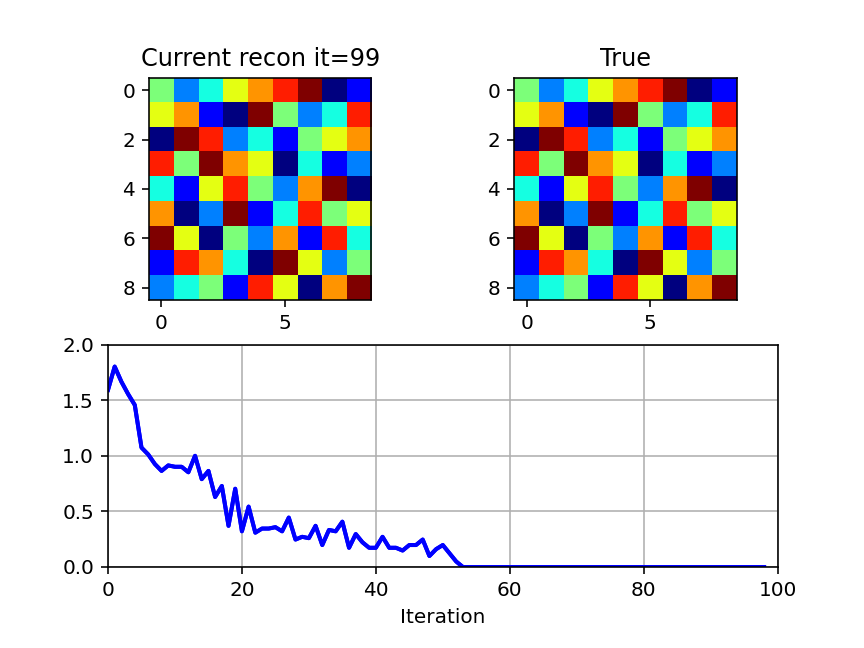

In [31]:
%matplotlib notebook

np.random.seed(42)
it_max = 100

beta = 1.3
gamma_A = -1/beta
gamma_B = 1/beta

# Initial iterate
x = [np.random.rand(N_symbols, N_symbols, N_symbols) for n in range(N_constraints)] 


e_vec = np.zeros(it_max)

fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(222)
im = ax.imshow(x_true_sudoku, cmap='jet')
ax.set_title("True")

ax1 = fig.add_subplot(221)

ax2 = fig.add_subplot(212)
ax2.set_xlim(0,it_max)
ax2.set_ylim(0,2)
ax2.set_xlabel("Iteration")
ax2.grid()

x_sol_prev = np.zeros((N_symbols,N_symbols,N_symbols))
for it in range(it_max):
    
    # Update rule - so-called the "Difference Map"
    x, x_sol = DM(x, beta, gamma_A, gamma_B)

    # Calculate averaged error
    e_vec[it] = np.mean(np.abs(return_sudoku(x_sol) - x_true_sudoku))
    

    # Clearing the axes every five iteration
    if it % 5 == 1:
        ax1.cla()
        ax2.cla()
        
        ax2.set_xlim(0,it_max)
        ax2.set_ylim(0,2)
        ax2.set_xlabel("Iteration")
        ax2.grid()
        
    if it % 3 == 0:
        # Visualise
        
        im = ax1.imshow(return_sudoku(x_sol), cmap='jet')
        ax1.set_title("Current recon it=%d" % it)
        
        ax2.plot(range(it), e_vec[0:it], 'b-', linewidth=2)
        
        
        fig.canvas.draw()

        time.sleep(0.05)

In [32]:
x_sol_sudoku = return_sudoku(x_sol)

print("Solution found")
print(x_sol_sudoku)

print("Ground truth")
print(x_true_sudoku)

print("Difference")
print(x_true_sudoku - x_sol_sudoku)



Solution found
[[5 3 4 6 7 8 9 1 2]
 [6 7 2 1 9 5 3 4 8]
 [1 9 8 3 4 2 5 6 7]
 [8 5 9 7 6 1 4 2 3]
 [4 2 6 8 5 3 7 9 1]
 [7 1 3 9 2 4 8 5 6]
 [9 6 1 5 3 7 2 8 4]
 [2 8 7 4 1 9 6 3 5]
 [3 4 5 2 8 6 1 7 9]]
Ground truth
[[5 3 4 6 7 8 9 1 2]
 [6 7 2 1 9 5 3 4 8]
 [1 9 8 3 4 2 5 6 7]
 [8 5 9 7 6 1 4 2 3]
 [4 2 6 8 5 3 7 9 1]
 [7 1 3 9 2 4 8 5 6]
 [9 6 1 5 3 7 2 8 4]
 [2 8 7 4 1 9 6 3 5]
 [3 4 5 2 8 6 1 7 9]]
Difference
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
